In [114]:
from data_utils import *
from kitti_utils import *
import matplotlib.pyplot as plt
# from publish_utils import *
import math

CONSTANTS_RADIUS_OF_EARTH = 6371000.     # meters (m)

def GPStoXY(lat, lon, ref_lat, ref_lon):
        # input GPS and Reference GPS in degrees
        # output XY in meters (m) X:North Y:East
        lat_rad = math.radians(lat)
        lon_rad = math.radians(lon)
        ref_lat_rad = math.radians(ref_lat)
        ref_lon_rad = math.radians(ref_lon)

        sin_lat = math.sin(lat_rad)
        cos_lat = math.cos(lat_rad)
        ref_sin_lat = math.sin(ref_lat_rad)
        ref_cos_lat = math.cos(ref_lat_rad)

        cos_d_lon = math.cos(lon_rad - ref_lon_rad)

        arg = np.clip(ref_sin_lat * sin_lat + ref_cos_lat * cos_lat * cos_d_lon, -1.0, 1.0)
        c = math.acos(arg)

        k = 1.0
        if abs(c) > 0:
            k = (c / math.sin(c))

        x = float(k * (ref_cos_lat * sin_lat - ref_sin_lat * cos_lat * cos_d_lon) * CONSTANTS_RADIUS_OF_EARTH)
        y = float(k * cos_lat * math.sin(lon_rad - ref_lon_rad) * CONSTANTS_RADIUS_OF_EARTH)

        return x, y


In [277]:
#定义使用GPS计算单位时间移动距离方法（速度）
def computer_great_circle_distance(lat1,lon1,lat2,lon2):
    delta_sigma = float(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+\
                        np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos(lon1*np.pi/180-lon2*np.pi/180))
    return 6371000.0*np.arccos(np.clip(delta_sigma,-1,1))

#画出单位时间移动距离（速度）
def plot_distance(path):
    gps_distance = []
    imu_distance = []
    prev_imu_data = None
    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)

        if prev_imu_data is not None:
            gps_distance += [computer_great_circle_distance(imu_data.lat,imu_data.lon,prev_imu_data.lat,prev_imu_data.lon)]
        prev_imu_data = imu_data
        imu_distance += [0.1*np.linalg.norm(imu_data[['vf','vl']])]

    plt.figure(figsize=(20,10))
    plt.plot(gps_distance, label='gps_distance')
    plt.plot(imu_distance, label='imu_distance')
    plt.legend()
    plt.show()

def get_odom_from_imu(path):
    prev_imu_data = None
    locations = []

    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)
        
        if prev_imu_data is not None:
            displacement = 0.1*np.linalg.norm(imu_data[['vf','vl']])
            x0, y0 = locations[-1]
            x1  = x0 + displacement * np.sin(imu_data.yaw)
            y1  = y0 + displacement * np.cos(imu_data.yaw)
            locations += [np.array([float(x1),float(y1)])]
        else:
            locations += [np.array([0,0])]    
            prev_imu_data =   imu_data     
    return locations

def plot_odom_from_imu(path):
    prev_imu_data = None
    locations = []

    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)
        
        if prev_imu_data is not None:
            displacement = 0.1*np.linalg.norm(imu_data[['vf','vl']])
            x0, y0 = locations[-1]
            x1  = x0 + displacement * np.sin(imu_data.yaw)
            y1  = y0 + displacement * np.cos(imu_data.yaw)
            locations += [np.array([float(x1),float(y1)])]
        else:
            locations += [np.array([0,0])]    
            prev_imu_data =   imu_data     
        
    plt.figure(figsize=(20,10))
    plt.plot(np.array(locations)[:, 0],np.array(locations)[:, 1])
    plt.show()


#画出gps 观测值轨迹
def plot_odom_from_gps(path):
    first_imu_data = None
    locations = []

    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)

        if first_imu_data is not None:
            x,y = GPStoXY(imu_data.lat,imu_data. lon, first_imu_data.lat, first_imu_data.lon)
            locations += [np.array([x,y])]
        else:
            first_imu_data = imu_data
        
        
    plt.figure(figsize=(20,10))

    plt.plot(np.array(locations)[:, 0],np.array(locations)[:, 1])
    plt.legend()
    plt.show()

def get_odom_from_gps(path):
    first_imu_data = None
    locations = []

    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)

        if first_imu_data is not None:
            x,y = GPStoXY(imu_data.lat,imu_data. lon, first_imu_data.lat, first_imu_data.lon)
            locations += [np.array([x,y])]
        else:
            first_imu_data = imu_data
    return locations

#fake odom数据，主要依据是odom在转弯时无法纠正打滑带来的误差
def get_odom_from_odom(path):
    prev_imu_data = None
    locations = []
    true_yaw = []
    fake_yaw = []

    files = sorted(os.listdir(path+"/oxts/data/"))
    for frame in files:
        imu_data = read_imu(path +"/oxts/data/"+ frame)
        
        if prev_imu_data is not None:
            displacement = 0.1*np.linalg.norm(imu_data[['vf','vl']])
            yaw_change = imu_data.yaw - true_yaw[-1]
            yaw_this = fake_yaw[-1] + yaw_change*1.03
            fake_yaw += [yaw_this]
            x0, y0 = locations[-1]
            x1  = x0 + displacement * np.sin(yaw_this)
            y1  = y0 + displacement * np.cos(yaw_this)
            locations += [np.array([float(x1),float(y1)])]
        else:
            locations += [np.array([0,0])]
            fake_yaw +=  [imu_data.yaw]
        prev_imu_data =   imu_data    
        true_yaw +=  [imu_data.yaw]
    return locations

#画出GPS IMU对路径观测的对比
def plot_odom_gps_imu_odom(path):

    plt.figure(figsize=(20,10))

    odom_imu = get_odom_from_imu(path)
    plt.plot(np.array(odom_imu)[:, 0],np.array(odom_imu)[:, 1], label='imu')
    

    odom_gps = get_odom_from_gps(path)
    plt.plot(np.array(odom_gps)[:, 0],np.array(odom_gps)[:, 1], label='gps')

    odom_odom = get_odom_from_odom(path)
    plt.plot(np.array(odom_odom)[:, 0],np.array(odom_odom)[:, 1], label='odom')
    
    plt.legend()
    plt.show()



In [278]:
path = '/media/ubuntu/zhi_chuan_len-/kitti/kitti_raw_data/2011_10_03/2011_10_03_drive_0027_sync'

In [279]:
# plot_distance(path)
# plot_odom_from_imu(path)
# plot_odom_from_gps(path)
# plot_odom_gps_imu_odom(path)

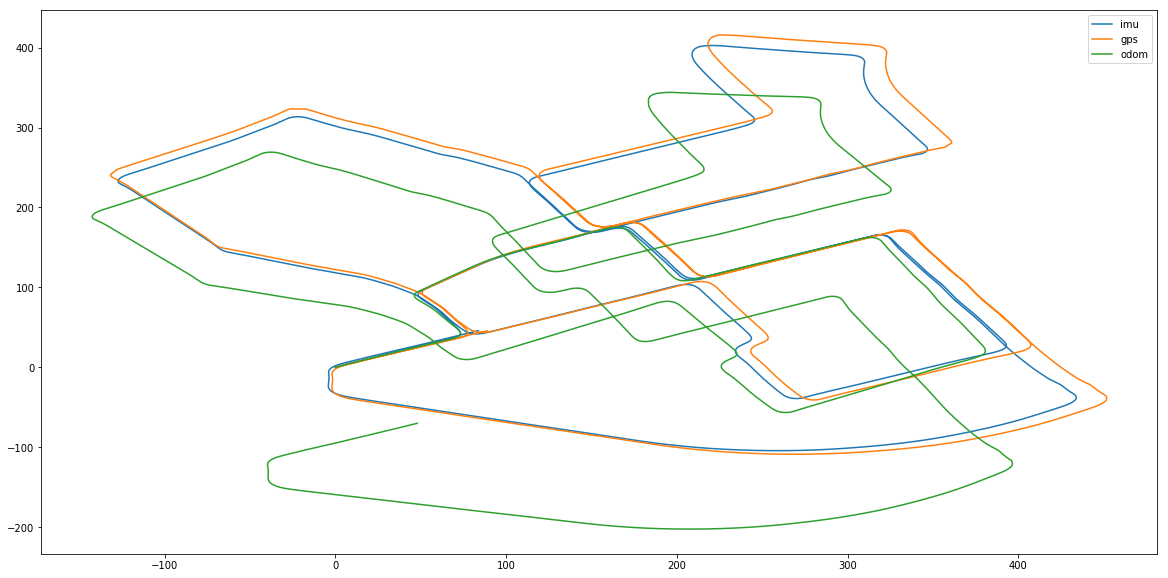

In [280]:
plot_odom_gps_imu_odom(path)